<img src="./Espresso-Coffee-Beans-Market.jpg">

<h1><center>☕Coffee sales prediction☕</center></h1>

# 1. Introduction

We recorded a lot of data during the first year of our chain. We are now going to analyze them to try to predict the sales we will make in the next few days. Enjoy ! 🤓


### Libraries 📚⬇

In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(22, 11)})
sns.set_context("poster")

# 2. The .csv files 📁

> 📌**Note**:
* `Items.csv` contains information about the things we sell in our store. Spoiler alert it's almost exclusively food and drinks.
* `Sales.csv` contains a list of the transactions made during the last year.

In [2]:
#data
items = pd.read_csv("./sales data/Items.csv", sep = ';', header = 1)
data = pd.read_csv("./sales data/Sales.csv", sep = ';', header = 1)

## Items 🥞

In [3]:
#Check items
items.head()

,Produit,Sweet / Savory,Drink / Food,Hot / Cold,Allergènes,Price
0,Pancake vegan,Sweet,Food,Hot,NaN,4
1,Pancake,Sweet,Food,Hot,"Dairy, Eggs",4
2,Nutella panini,Sweet,Food,Hot,Nuts,3
3,Waffles,Sweet,Food,Hot,"Dairy, Eggs",3
4,Cinnamon roll,Sweet,Food,Cold,"Nuts, Eggs, Dairy",4


In [4]:
print("There is actually", items.shape[0], "different items in the dataset")
print(items['Produit'].value_counts())

There is actually 31 different items in the dataset
LANE Coffee                1
Caramel macchiato          1
Cinnamon roll              1
Nutella panini             1
Tea                        1
Avocado  toast             1
Pancake vegan              1
Muffin                     1
Mac & cheese               1
Cake                       1
Pancake                    1
Brownie                    1
Salad                      1
Muffin vegan               1
Grilled cheese vegan       1
Cappucino                  1
Wrap vegan                 1
Grilled cheese             1
Chaï latte                 1
Coffee                     1
Sandwich                   1
Latte coffee               1
Tiramisu                   1
White chocolate cookie     1
Iced tea                   1
Foccacia                   1
Mineral water              1
Apple juice                1
Mozzarella pesto panini    1
Iced coffee                1
Waffles                    1
Name: Produit, dtype: int64


## Transactions 💳

In [5]:
#Check data
data.head()

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Coffee,2016-10-30 09:58:11,Morning,Weekend
1,2,Pancake vegan,2016-10-30 10:05:34,Morning,Weekend
2,2,Pancake vegan,2016-10-30 10:05:34,Morning,Weekend
3,3,Cappucino,2016-10-30 10:07:57,Morning,Weekend
4,3,Nutella panini,2016-10-30 10:07:57,Morning,Weekend


In [6]:
#Dates
data['DateTime'] = pd.to_datetime(data.DateTime, format = '%Y-%m-%d %H:%M:%S')
data['Year'] = data['DateTime'].dt.year 
data['Month'] = data['DateTime'].dt.month
data['BigDate'] = data['DateTime'].dt.date
data['Date'] = data['DateTime'].dt.to_period('m')
data['Date'] = data['Date'].dt.to_timestamp()

data.head()

,TransactionNo,Items,DateTime,Daypart,DayType,Year,Month,BigDate,Date
0,1,Coffee,2016-10-30 09:58:11,Morning,Weekend,2016,10,2016-10-30,2016-10-01
1,2,Pancake vegan,2016-10-30 10:05:34,Morning,Weekend,2016,10,2016-10-30,2016-10-01
2,2,Pancake vegan,2016-10-30 10:05:34,Morning,Weekend,2016,10,2016-10-30,2016-10-01
3,3,Cappucino,2016-10-30 10:07:57,Morning,Weekend,2016,10,2016-10-30,2016-10-01
4,3,Nutella panini,2016-10-30 10:07:57,Morning,Weekend,2016,10,2016-10-30,2016-10-01


# 3. Join datasets

We will join the two dataset to have a price to each transactions.

In [7]:
# Rename to merge
items.rename(columns={'Produit':'Items'}, inplace=True)

In [8]:
data['Items'].value_counts()

Coffee                      8798
Tea                         1435
Cake                        1025
LANE Coffee                  858
Sandwich                     771
Brownie                      691
Cinnamon roll                616
White chocolate cookie       603
Cappucino                    590
Avocado toast                517
Salad                        473
Mozzarella pesto panini      465
Caramel macchiato            378
Muffin                       373
Iced tea                     369
Tiramisu                     339
Wrap vegan                   312
Pancake vegan                277
Chaï latte                   262
Iced Coffee                  260
Waffles                      224
Nutella panini               149
Mineral water                139
Focaccia                     136
Pancake                      133
Mac and cheese                89
Grilled cheese                83
Apple juice                   65
Grilled cheese vegan          22
Muffin vegan                  17
Avocado Av

In [9]:
# Merge (inner)
df = pd.merge(data, items, on='Items', how='inner')
df = df.drop(columns=['TransactionNo', 'Sweet / Savory', 'Drink / Food', 'Hot / Cold', 'Allergènes'])
df.head()

,Items,DateTime,Daypart,DayType,Year,Month,BigDate,Date,Price
0,Coffee,2016-10-30 09:58:11,Morning,Weekend,2016,10,2016-10-30,2016-10-01,2
1,Coffee,2016-10-30 10:13:03,Morning,Weekend,2016,10,2016-10-30,2016-10-01,2
2,Coffee,2016-10-30 10:13:03,Morning,Weekend,2016,10,2016-10-30,2016-10-01,2
3,Coffee,2016-10-30 10:19:12,Morning,Weekend,2016,10,2016-10-30,2016-10-01,2
4,Coffee,2016-10-30 10:20:51,Morning,Weekend,2016,10,2016-10-30,2016-10-01,2


In [10]:
df['Items'].value_counts()

Coffee                     8798
Tea                        1435
Cake                       1025
LANE Coffee                 858
Sandwich                    771
Brownie                     691
Cinnamon roll               616
White chocolate cookie      603
Cappucino                   590
Salad                       473
Mozzarella pesto panini     465
Muffin                      373
Iced tea                    369
Tiramisu                    339
Wrap vegan                  312
Pancake vegan               277
Waffles                     224
Nutella panini              149
Mineral water               139
Pancake                     133
Apple juice                  65
Grilled cheese vegan         22
Muffin vegan                 17
Name: Items, dtype: int64

In [11]:
#Groups
dataByDate = df.groupby(by='BigDate').sum()
dataByMonth = df.groupby(by=['Year','Month']).sum()
dataByItem = df.groupby(by='Items', as_index=False)

dataByDate = dataByDate.drop(columns=['Year','Month'])
dataByDate.head()

,Price
BigDate,
2016-01-11,383
2016-01-12,217
2016-02-11,401
2016-02-12,273
2016-03-11,495


C:\Users\enzom\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


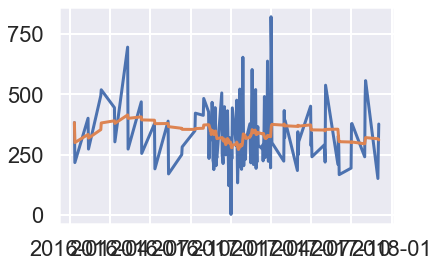

In [12]:
#Price by date
dataByDate['SMA20'] = dataByDate.Price.rolling(20, min_periods=1).mean()
# dataByDate['CMA'] = dataByDate.Price.expanding().mean()
# dataByDate['EMA0.1'] = dataByDate.Price.ewm(alpha=0.1, adjust=False).mean()
# dataByDate['EMA0.3'] = dataByDate.Price.ewm(alpha=0.3, adjust=False).mean()

plt.plot(dataByDate)
# plt.legend(['Price', 'SMA5', 'CMA', 'EMA0.1', 'EMA0.3'])